# 0. Google Colab Setup

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('./drive/MyDrive/cmpt419 affective computing project')

In [ ]:
!pip install dlib

In [ ]:
!pip install imutils

In [ ]:
!pip install --upgrade imutils

# 1. Generate Ground Truth Attention Map
+ The ROI Attention module needs groud truth regions corresponding to specific activate action units of the face image. Thus we need to first generate ground-truth attention map for this component before hand.
+ First, detect facial landmarks for each image, then use these landmarks to define each action units. More specifically, we us landmarks as the initial regions of interest, and use ellipses to fit to this region, finally smooth the image.

> Notice that reproduce images in electronic or print media,to use only those from the following subjects:
   - SN001, SN002, SN003, SN004, SN006, SN007, SN008, SN010, SN011, SN012, SN013, SN016, SN017, SN018, SN021, SN023, SN024, SN025, SN026, SN027, SN028, SN029, SN030, SN031, SN032(NOT to use: SN005 and SN009)

In [ ]:
import numpy as np
import pandas as pd
import cv2
import dlib
from google.colab.patches import cv2_imshow
from imutils import face_utils

In [ ]:
LABEL_PATH = './dataset/labels'
IMAGE_PATH = './dataset/frames'

## 1.1 Use dlib to detect face in a image

In [ ]:
# test dlib faces ddetector on a sample image
ddetector = dlib.get_frontal_face_detector()
# dlib  library path
dpredictor = dlib.shape_predictor('./face detection/shape_predictor_68_face_landmarks.dat')

In [ ]:
test = os.listdir('./dataset/frames/SN001')
test[-1]

'frame_845.jpg'

In [ ]:
# test_label = os.listdir('./dataset/labels/SN001/SN001_au1.txt')
label_df = pd.read_csv('./dataset/labels/SN001/SN001_au1.txt',  delimiter=',', header=None)
label_df.head(3)

,0,1
0,1,0
1,2,0
2,3,0


In [ ]:
# load sample image
sample_path = './dataset/frames/SN001/frame_845.jpg'
sample_label_path = './dataset/labels'
# sampel_img = np.load(sample_path, allow_pickle=True)
# face = ddetector(sample_img)

color_image = cv2.imread(sample_path)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
np_gray = np.array(gray_image)

faces = ddetector(np_gray)

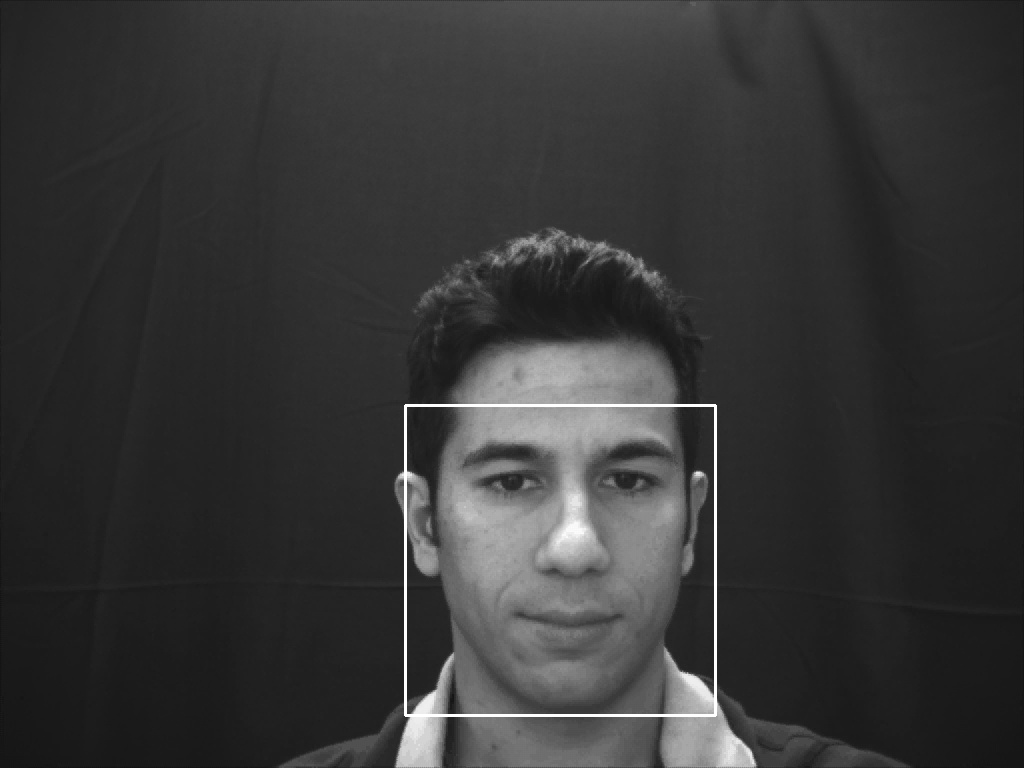

In [ ]:
# check the detected faces
for face in faces:
  x, y, w, h = face.left(), face.top(), face.width(), face.height()
  cv2.rectangle(gray_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  cv2_imshow(gray_image)

In [ ]:
# use face to furtherly detect the facial landmarks
x1, y1, w, h = face_utils.rect_to_bb(faces[0])
shapes = dpredictor(np_gray, faces[0])
shapes = face_utils.shape_to_np(shapes)

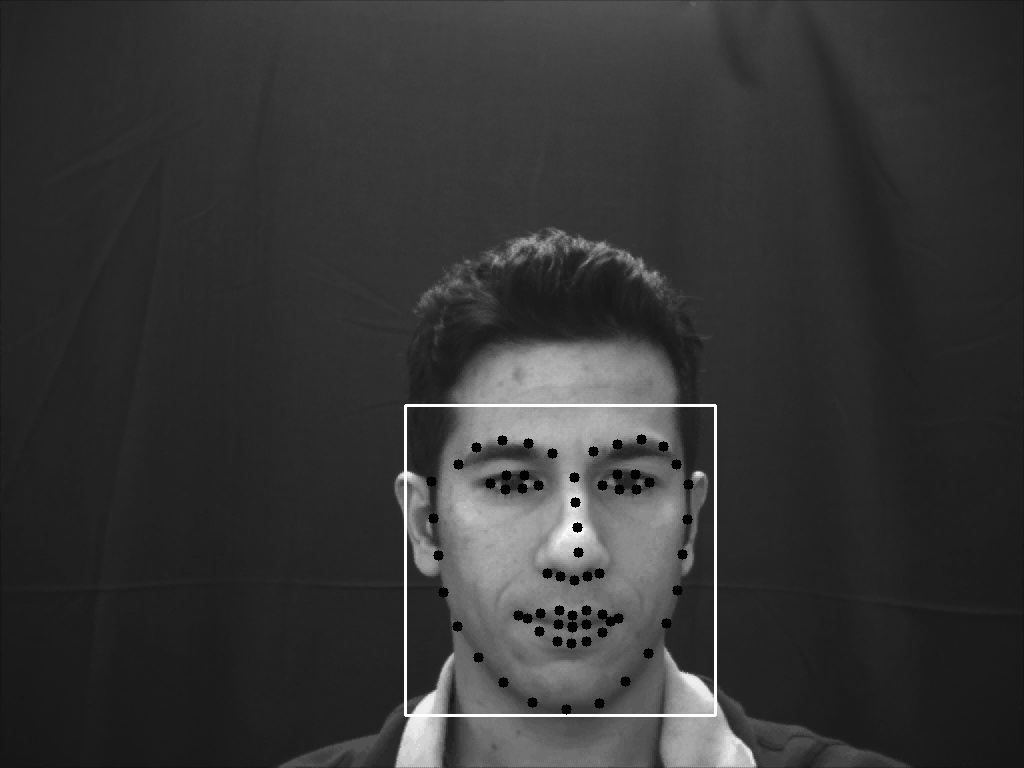

In [ ]:
# check the 68 shapes detected
shapes.shape

for point in shapes:
  x, y = point
  cv2.circle(gray_image, (x, y), 5, (0, 255, 0), -1)
cv2_imshow(gray_image)

## 1.2 generate attention region for each AU
+ The ground truth attention map uses the detected facial landmarks and use the landmark as central and add an elliptical around this area.

In [ ]:
'''
Generate the ground truth attention region for each AU
This part of code is from: https://github.com/rakutentech/FAU_CVPR2021/blob/main/Prepare_data.py
'''
def AU_plot_ellipsoid(gray1,au,x,shapes):
    [x1,y1,x2,y2,w,h] = x

    att_map = np.zeros((gray1.shape[0],gray1.shape[1]))

    if au==0:
        (l_x1,l_y1) = (shapes[20])
        (r_x2,r_y2) = (shapes[23])
        cv2.ellipse(gray1,(l_x1,l_y1),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(r_x2,r_y2),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(l_x1,l_y1),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(r_x2,r_y2),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==1:
        (l_x1,l_y1) = (shapes[18])
        (r_x2,r_y2) = (shapes[25])
        cv2.ellipse(gray1,(l_x1,l_y1),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(r_x2,r_y2),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(l_x1,l_y1),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(r_x2,r_y2),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==2:
        l_x,l_y = (shapes[19])
        r_x,r_y = (shapes[24])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==3:
        (l_x1,_) = (shapes[36])
        (_,l_y1) = (shapes[38])
        (r_x1,_) = (shapes[39])
        (_,r_y1) = (shapes[41])
        (l_x2,_) = (shapes[42])
        (_,l_y2) = (shapes[44])
        (r_x2,_) = (shapes[45])
        (_,r_y2) = (shapes[47])
        cv2.ellipse(gray1,(int((l_x1+r_x1)/2),int((l_y1+r_y1)/2)),
                    (max(int((r_x1-l_x1)/2),0),max(int((r_y1-l_y1)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x1+r_x1)/2),int((l_y1+r_y1)/2)),
                    (max(int((r_x1-l_x1)/2),0),max(int((r_y1-l_y1)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(gray1,(int((l_x2+r_x2)/2),int((l_y2+r_y2)/2)),
                    (max(int((r_x2-l_x2)/2),0),max(int((r_y2-l_y2)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x2+r_x2)/2),int((l_y2+r_y2)/2)),
                    (max(int((r_x2-l_x2)/2),0),max(int((r_y2-l_y2)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)



    elif au==4:
        (l_x1,l_y1) = (shapes[41])
        (r_x1,r_y1) = (shapes[46])
        cv2.ellipse(gray1,(l_x1-round(w/10),l_y1+round(h/6)),(round(w/10),round(h/10)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(r_x1-round(w/10),r_y1+round(h/6)),(round(w/10),round(h/10)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(l_x1-round(w/10),l_y1+round(h/6)),(round(w/10),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(r_x1+round(w/10),r_y1+round(h/6)),(round(w/10),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==5:
        (l_x1,_) = (shapes[36])
        (_,l_y1) = (shapes[38])
        (r_x1,_) = (shapes[39])
        (_,r_y1) = (shapes[41])
        (l_x2,_) = (shapes[42])
        (_,l_y2) = (shapes[44])
        (r_x2,_) = (shapes[45])
        (_,r_y2) = (shapes[47])
        cv2.ellipse(gray1,(int((l_x1+r_x1)/2),int((l_y1+r_y1)/2)),
                    (max(int((r_x1-l_x1)/2),0),max(int((r_y1+10-l_y1+10)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(int((l_x2+r_x2)/2),int((l_y2+r_y2)/2)),
                    (max(int((r_x2-l_x2)/2),0),max(int((r_y2+10-l_y2+10)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x1+r_x1)/2),int((l_y1+r_y1)/2)),
                    (max(int((r_x1-l_x1)/2),0),max(int((r_y1+10-l_y1+10)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(int((l_x2+r_x2)/2),int((l_y2+r_y2)/2)),
                    (max(int((r_x2-l_x2)/2),0),max(int((r_y2+10-l_y2+10)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==6:
        (l_x1,l_y1) = (shapes[29])
        (r_x1,r_y1) = (shapes[31])
        (r_x2,r_y2) = (shapes[35])

        cv2.ellipse(gray1,(int(r_x1),int(l_y1)),(20,20),0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(int(r_x2),int(l_y1)),(20,20),0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int(r_x1),int(l_y1)),(20,20),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(int(r_x2),int(l_y1)),(20,20),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==7:
        l_x,_ = (shapes[48])
        r_x,_ = (shapes[54])
        _,l_y = (shapes[50])
        _,r_y = (shapes[63])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==8:
        l_x,l_y = (shapes[48])
        r_x,r_y = (shapes[54])
        cv2.ellipse(gray1,(l_x,l_y),(round(w/8),round(h/10)),0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(r_x,r_y),(round(w/8),round(h/10)),0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(l_x,l_y),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(r_x,r_y),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==9:
        l_x,l_y = (shapes[48])
        r_x,r_y = (shapes[54])
#         print(l_x,l_y,r_x,r_y)
        cv2.ellipse(gray1,(l_x,l_y),(round(w/8),round(h/10)),0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(r_x,r_y),(round(w/8),round(h/10)),0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(l_x,l_y),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(r_x,r_y),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==10:
        l_x,l_y = (shapes[48])
        r_x,r_y = (shapes[54])
        cv2.ellipse(gray1,(l_x,l_y),(round(w/8),round(h/10)),0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(r_x,r_y),(round(w/8),round(h/10)),0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(l_x,l_y),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(r_x,r_y),(round(w/8),round(h/10)),
                    0,0,360,(255,255,255),cv2.FILLED)



    elif au==11:
        l_x,l_y = (shapes[59])
        r_x,r_y = (shapes[9])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)



    elif au==12:
        l_x,_ = (shapes[48])
        r_x,_ = (shapes[54])
        _,l_y = (shapes[50])
        _,r_y = (shapes[57])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)


    elif au==13:
        l_x,_ = (shapes[48])
        r_x,_ = (shapes[54])
        _,l_y = (shapes[50])
        _,r_y = (shapes[57])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)


    elif au==14:
        l_x,_ = (shapes[48])
        r_x,_ = (shapes[54])
        _,l_y = (shapes[50])
        _,r_y = (shapes[57])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==15:
        l_x,l_y = (shapes[48])
        r_x,r_y = (shapes[54])
        _,l_y = (shapes[50])
        _,r_y = (shapes[57])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)

    elif au==16:
        l_x,_ = (shapes[48])
        r_x,_ = (shapes[54])
        _,l_y = (shapes[50])
        _,r_y = (shapes[57])
        cv2.ellipse(gray1,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x+r_x)/2),int((l_y+r_y)/2)),
                    (max(int((r_x-l_x)/2),0),max(int((r_y-l_y)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)
    elif au==17:
        (l_x1,_) = (shapes[36])
        (_,l_y1) = (shapes[38])
        (r_x1,_) = (shapes[39])
        (_,r_y1) = (shapes[41])
        (l_x2,_) = (shapes[42])
        (_,l_y2) = (shapes[44])
        (r_x2,_) = (shapes[45])
        (_,r_y2) = (shapes[47])
        cv2.ellipse(gray1,(int((l_x1+r_x1)/2),int((l_y1+r_y1)/2)),
                    (max(int((r_x1-l_x1)/2),0),max(int((r_y1+10-l_y1+10)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(gray1,(int((l_x2+r_x2)/2),int((l_y2+r_y2)/2)),
                    (max(int((r_x2-l_x2)/2),0),max(int((r_y2+10-l_y2+10)/2),0)),
                    0,0,360,(255,255,255),2)
        cv2.ellipse(att_map,(int((l_x1+r_x1)/2),int((l_y1+r_y1)/2)),
                    (max(int((r_x1-l_x1)/2),0),max(int((r_y1+10-l_y1+10)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)
        cv2.ellipse(att_map,(int((l_x2+r_x2)/2),int((l_y2+r_y2)/2)),
                    (max(int((r_x2-l_x2)/2),0),max(int((r_y2+10-l_y2+10)/2),0)),
                    0,0,360,(255,255,255),cv2.FILLED)

    img_h, img_w= np.shape(gray1)

    xw1 = max(int(x1 - 10), 0)  #<---left side
    yw1 = max(int(y1 - 10), 0)  #<---head
    xw2 = min(int(x2 + 10), img_w - 1) #<---right side
    yw2 = min(int(y2 + 10), img_h - 1) #<--- bottom

    att_map1 = cv2.resize(att_map[yw1:yw2,xw1:xw2], dsize=(28,28))
    return att_map1


In [ ]:
# use it to generate attention map for each AU
AU_CNT = 12
x1 = x
y1 = y
x2 = x1 + w
y2 = y + h

for i in range(AU_CNT):
  au = i
  att_map = AU_plot_ellipsoid(np_gray, au, [x1,y1,x2,y2,w,h], shapes)
  att_map = cv2.blur(att_map,(3,3))
  attmap_resized = cv2.resize(att_map, dsize=(224,224))
  cv2_imshow(att_map)

## 1.3 Adjust current dataset structure for training/test data generation
+ The current DISFA dataset put images and labels in seperate files, which is not suitable for data generation.
+ The AU label for each data smaple also stores in seperate txt files, need to combine all au label into one single vector for each sample.
+ Store the final img, attention map, and label separatly

In [ ]:
# not necessary
img_list = [] # store the name of each image("SN001_frame_28.jpg")
img_path_list = [] # store each image's path
for subject in os.listdir(IMAGE_PATH):
  subject_path = os.path.join(IMAGE_PATH, subject)
  for frame in os.listdir(subject_path):
    img_list.append("{}_{}".format(subject, frame))
    curr_path = os.path.join(subject_path, frame)
    img_path_list.append(curr_path)

In [ ]:
# concat each au txt file for each subject and store each subject's gt labels
# use subject index and the frame number to retrieve the label vectors
au_list = [1,2,4,5,6,9,12,15,17,20,25,26] # the au that provided by DISFA dataset
all_aulist = [1,2,4,5,6,7,9,10,12,14,15,17,20,23,24,25,26,43]

def au_df(subject):
  path = os.path.join(LABEL_PATH, subject)
  dfs = []
  for au in au_list: # notice that keep the au sequence for further usage
    au_txt = "{}_au{}.txt".format(subject, au)
    print(au_txt)
    curr_path = os.path.join(path, au_txt)
    dfs.append(pd.read_csv(curr_path, header = None, index_col = 0))
  df = pd.concat(dfs, axis=1)
  return df

In [ ]:
# #generate the vector dataframe for each subject and store it
# paths = os.listdir(IMAGE_PATH)
# for subject in paths:
#   sdf = au_df(subject)
#   sdf.to_csv('./dataset/vector_labels/{}.csv'.format(subject), index=False)

In [ ]:
# check the label vector stored
df = pd.read_csv('./dataset/vector_labels/SN001.csv')
df.head(3)

,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.10,1.11
0,0,0,0,0,0,0,2,0,0,0,0,0
1,0,0,0,0,0,0,2,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,0,0


In [ ]:
img_list[0]

'SN001_frame_3846.jpg'

## 1.4 Generate attention map
+ Here we split the DISFA to 3 folds for training and testing

In [ ]:
"""
This part of code is adapted from: https://github.com/rakutentech/FAU_CVPR2021/blob/main/Prepare_data.py
Certain necessary changes have been made according to DISFA dataset and our settings
"""

fold1 = ['SN002','SN010','SN001','SN026','SN027','SN030','SN032','SN009','SN016']
fold2 = ['SN006','SN011','SN012','SN013','SN018','SN021','SN024','SN028','SN031']
fold3 = ['SN003','SN004','SN005','SN007','SN008','SN017','SN023','SN025','SN029']

index_list = [] # store the index = 4845 * (subject_idx-1) + frame - 1
index_im_list = [] # store the img_path

images = img_list

for _ in range(3):
    index_list.append([])
    index_im_list.append([])
for im in range(len(images)):
    subject = images[im].split('_')[0]
    subject_idx = int(subject[2:])
    img_idx = 4845 * (subject_idx-1) + int(images[im].split('_')[2][:-4]) - 1

    if subject in fold1:
        index_list[0].append(img_idx);index_im_list[0].append(img_path_list[im])
    elif subject in fold2:
        index_list[1].append(img_idx);index_im_list[1].append(img_path_list[im])
    elif subject in fold3:
        index_list[2].append(img_idx);index_im_list[2].append(img_path_list[im])

In [ ]:
index_im_list[0][0].split('/')[4].split()

['frame_3846.jpg']

In [ ]:
# load the label vector for all subjects
vector_label_dic = {}
for subject in os.listdir(IMAGE_PATH):
  df_path = './dataset/vector_labels/{}.csv'.format(subject)
  df = pd.read_csv(df_path)
  vector_label_dic[subject] = df

In [ ]:
vector_label_dic['SN001'].iloc[0].values

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [ ]:
index_im_list[0][0].split('/')

['.', 'dataset', 'frames', 'SN001', 'frame_3846.jpg']

In [ ]:
batch_size=64
AU_count =18 # the model can detect total 18 AU
ind1 = [0,1,2,4,5,7,8,9,10,11,13,14] # the index of au that BP4D contains

for foldno in range(3):
    x = index_im_list[foldno] # get the current fold
    sample_idx = 0
    batch = 0
    print('entering ... ',len(x))

    while sample_idx  < len(x):

        # three inputs to the model: the training img, the label vector, and the ground truth attention map
        x_train = np.zeros((batch_size, 224, 224, 1), dtype='float32')
        y_train = np.zeros((batch_size,AU_count ), dtype='float32')
        x_train_att = np.zeros((batch_size, 28,28,AU_count), dtype='float32')
        row=0

        while row <batch_size:
            if sample_idx>=len(x):
                break
            # load img and convert to np array
            img_path = x[sample_idx]
            subject = img_path.split('/')[3]
            color_image = cv2.imread(img_path)
            gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
            gray = np.array(gray_image)

            # detect face and generate attention maps
            faces = ddetector(gray)
            if len(faces)>0: #only deal with img that has face
                (x1, y1, w, h) = face_utils.rect_to_bb(faces[0]) #in case multiple faces are detected
                shapes = dpredictor(gray, faces[0])
                shapes = face_utils.shape_to_np(shapes)

                x2 = x1+w
                y2 = y1+h
                img_h, img_w= np.shape(gray)
                xw1 = max(int(x1 -0), 0)  #<---left side
                yw1 = max(int(y1  -0), 0)  #<---head
                xw2 = min(int(x2 + 0), img_w - 1) #<---right side
                yw2 = min(int(y2 + 0), img_h - 1) #<--- bottom
                im_original = gray[yw1:yw2,xw1:xw2].copy() # crop the face out of the original img

                # get the corresponding label vector of this frame
                frame_idx = index_list[foldno][sample_idx]//4845 # 4845 is the total number of frames each subject has
                y = vector_label_dic[subject].iloc[frame_idx].values

                # map the DISFA au labels (total 12 labels) to the model au labels(total 18 labels)
                test1 = y
                test = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                test[:5] = test1[:5]
                test[6] = test1[5]
                test[8] = test1[6]
                test[10:13] = test1[7:10]
                test[15:17] = test1[-2:]

                y = np.array(test,dtype=float)
                full_att_map = np.zeros((1,224,224,AU_count))
                for i in range(AU_count): # generate au attention map for each different au
                        au = i
                        att_map = AU_plot_ellipsoid(gray,au,[x1,y1,x2,y2,w,h],shapes)
                        att_map = cv2.blur(att_map,(3,3))

                        attmap_resized = cv2.resize(att_map, dsize=(224,224))
                        full_att_map[0,:,:,i] = attmap_resized

                im_rz = np.expand_dims(cv2.resize(im_original, dsize=(224,224)),axis=0)
                x_train[row,...] = np.expand_dims(im_rz,axis=-1)
                x_train_att[row,...] = cv2.resize(np.squeeze(full_att_map),dsize=(28,28))/255.
                # y_train[row,...] = [y[i] for i in ind1]
                y_train[row,...] = y
                # index = np.where(y==1)
                row+=1
            sample_idx += 1
        x_train1 = x_train/255.
        x_train1_att = np.expand_dims(x_train_att.max(axis=-1),axis=-1)
        batch+=1
        print(batch,im_rz.shape,x_train.shape,x_train_att.shape,y_train.shape,
              './dataset/DISFA_fold'+str(foldno)+'_'+str(sample_idx))
        np.savez('./dataset/DISFA_fold'+str(foldno)+'_'+str(sample_idx),x_train1=x_train1,y_train=y_train,x_train_att=x_train_att)

entering ...  24224
1 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_64
2 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_128
3 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_192
4 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_256
5 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_320
6 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_384
7 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_448
8 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_512
9 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_576
10 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_640
11 (1, 224, 224) (64, 224, 224, 1) (64, 28, 28, 18) (64, 18) ./dataset/DISFA_fold0_704
12 (1, 224, 224) (64, 224, 224, 1